In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score,confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel

In [27]:
data =pd.read_csv('train.csv')
data

,Date,Open,High,Low,Adj Close,Volume,sma,rsi,ma,std_dev,upperband,lowerband,EMA12,EMA26,MACD,Signal_Line,MACD_Histogram,Close
0,2008-02-26,61.184048,61.877071,60.887035,34.932198,59821230,58.0407,65.7439,58.0407,3.8147,65.6701,50.4113,60.024440,58.772403,1.252037,1.071421,0.180617,61.778069
1,2008-02-27,62.174080,62.966106,62.075077,35.603970,94417042,58.7337,76.5151,58.7337,3.3348,65.4033,52.0641,60.477004,59.083048,1.393957,1.135928,0.258029,62.966106
2,2008-02-29,61.976074,62.867104,60.986038,34.484344,64072603,59.2584,69.6296,59.2584,2.7428,64.7440,53.7728,60.555317,59.224010,1.331307,1.175004,0.156303,60.986038
3,2008-03-03,59.500992,60.095009,59.401985,33.980511,47462048,59.6049,63.8889,59.6049,2.3407,64.2863,54.9235,60.484501,59.288528,1.195972,1.179197,0.016775,60.095009
4,2008-03-04,59.500992,62.372086,59.500992,35.212097,74207617,59.9713,64.4531,59.9713,2.1379,64.2471,55.6955,60.759667,59.509607,1.250060,1.193370,0.056690,62.273083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4008,2024-06-24,958.000000,960.000000,940.000000,940.000000,66391994,896.5500,62.2896,896.5500,49.3318,995.2136,797.8864,930.259943,894.505273,35.754671,30.524659,5.230011,940.000000
4009,2024-06-25,925.000000,945.000000,923.000000,945.000000,57368432,900.3500,62.6667,900.3500,50.0203,1000.3906,800.3094,932.527644,898.245623,34.282021,31.276132,3.005890,945.000000
4010,2024-06-26,951.000000,960.000000,951.000000,960.000000,44967166,905.1000,65.2733,905.1000,50.9880,1007.0760,803.1240,936.754161,902.820021,33.934139,31.807733,2.126406,960.000000
4011,2024-06-27,951.000000,961.000000,949.000000,960.000000,39729446,910.2500,66.9967,910.2500,51.0757,1012.4014,808.0986,940.330444,907.055575,33.274868,32.101160,1.173708,960.000000


In [28]:
features=data.columns[1:-1]
# features=['Open', 'High', 'Low', 'Adj Close', 'EMA12']
features

Index(['Open', 'High', 'Low', 'Adj Close', 'Volume', 'sma', 'rsi', 'ma',
       'std_dev', 'upperband', 'lowerband', 'EMA12', 'EMA26', 'MACD',
       'Signal_Line', 'MACD_Histogram'],
      dtype='object')

In [35]:
def pca_analyze(x_train, x_test, y_train, y_test):

    best_n_components = 0
    best_score = -float('inf')
    best_top_features = None
    best_pca = None

    # print("Feature matrix (x):")
    # print(x_train)
    
    for i in range(1, x_train.shape[1] + 1):
        pca = PCA(n_components=i, whiten=True)
        pca.fit(x_train)
        
        # Calculate some score metric (e.g., explained variance ratio)
        score = np.sum(pca.explained_variance_ratio_[:i])
        
        # Get the top features for the current number of components
        # Summarize the loadings of the components
        components = pca.components_
        feature_loadings = np.abs(components).mean(axis=0)
        top_features_indices = np.argsort(feature_loadings)[::-1][:i]
        top_features = [features[idx] for idx in top_features_indices]
        
        # print(f"For {i} components, Explained variance ratio: {score}")
        # print(f"Top features for {i} components: {top_features}")

        if score > best_score:
            best_score = score
            best_n_components = i
            best_top_features = top_features
            best_pca = pca
    
    # print(f"Best Explained variance ratio: {best_score} with {best_n_components} components")
    # print(f"Top features: {best_top_features}")

    return best_top_features, best_pca

def pca_and_svr(features):
    tdf = pd.DataFrame()
    tdf['Target'] = data['Close']

    x = data[features].values
    y = tdf['Target'].values
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=39830)

    pca_features,pca=pca_analyze(x_train, x_test, y_train, y_test)
    print(f"best features:{pca_features}")
    x = data[pca_features].values
    y = tdf['Target'].values
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=39830)
    pca_features,pca=pca_analyze(x_train, x_test, y_train, y_test)
    
    x_train_pca = pca.transform(x_train)
    x_test_pca = pca.transform(x_test)

    svr = SVR(kernel='rbf', C=100, gamma='auto')
    svr.fit(x_train_pca, y_train)

    score = svr.score(x_test_pca, y_test)
    print("R-squared score:", score)

    predictions = svr.predict(x_test_pca)

    merror = mean_squared_error(y_test, predictions)
    print('平均方差：{}'.format(merror))

    # 计算均方根误差
    rmse = np.sqrt(merror)
    print('均方根误差 (RMSE): {}'.format(rmse))

    # 计算平均绝对误差
    mae = mean_absolute_error(y_test, predictions)
    print('平均绝对误差 (MAE): {}'.format(mae))

    # 计算 R-squared score 使用 r2_score
    r2 = r2_score(y_test, predictions)
    print("R-squared score (使用 r2_score):", r2)

    tolerance_percentage = 0.01  # 5%

    # 计算容忍度阈值
    tolerance_threshold = tolerance_percentage * np.abs(y_test)

    # 计算绝对误差
    absolute_errors = np.abs(predictions - y_test)

    # 计算在容忍度范围内的正确比率
    correct_within_tolerance = np.mean(absolute_errors <= tolerance_threshold)

    # 输出正确比率
    print(f'在容忍度 {tolerance_percentage*100}% 范围内的正确比率: {correct_within_tolerance:.2f}%')

pca_and_svr(features)

    

best features:['Low', 'Open', 'High', 'EMA26', 'Adj Close', 'rsi', 'Signal_Line', 'upperband', 'lowerband', 'MACD', 'EMA12']
R-squared score: 0.9380516381610501
平均方差：264.5240748914427
均方根误差 (RMSE): 16.26419610344891
平均绝对误差 (MAE): 6.746278477203324
R-squared score (使用 r2_score): 0.9380516381610501
在容忍度 1.0% 范围内的正确比率: 0.72%


In [36]:
def pca_analyze(x_train, x_test, y_train, y_test, features):
    best_n_components = 0
    best_score = -float('inf')
    best_pca = None

    for i in range(1, x_train.shape[1] + 1):
        pca = PCA(n_components=i, whiten=True)
        x_train_pca = pca.fit_transform(x_train)
        x_test_pca = pca.transform(x_test)
        
        score = np.sum(pca.explained_variance_ratio_)
        
        if score > best_score:
            best_score = score
            best_n_components = i
            best_pca = pca
    
    print(f"Best Explained variance ratio: {best_score} with {best_n_components} components")
    return best_pca, best_n_components

def pca_and_svr(features):
    tdf = pd.DataFrame()
    tdf['Target'] = data['Close']

    # 使用全部特征进行 PCA 分析
    x = data[features].values
    y = tdf['Target'].values
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=39830)

    pca, n_components = pca_analyze(x_train, x_test, y_train, y_test, features)
    
    print(f"Number of components: {n_components}")

    # 应用最佳 PCA 转换
    x_train_pca = pca.transform(x_train)
    x_test_pca = pca.transform(x_test)

    # 训练 SVR 模型
    svr_model = SVR(kernel='rbf', C=100, gamma='scale')
    svr_model.fit(x_train_pca, y_train)

    # 评估模型
    score = svr_model.score(x_test_pca, y_test)
    print("R-squared score:", score)

    predictions = svr_model.predict(x_test_pca)
    merror = mean_squared_error(y_test, predictions)
    print('均方误差 (MSE): {}'.format(merror))

    rmse = np.sqrt(merror)
    print('均方根误差 (RMSE): {}'.format(rmse))

    mae = mean_absolute_error(y_test, predictions)
    print('平均绝对误差 (MAE): {}'.format(mae))

    r2 = r2_score(y_test, predictions)
    print("R-squared score (使用 r2_score):", r2)

    tolerance_percentage = 0.01  # 1%

    # 计算容忍度阈值
    tolerance_threshold = tolerance_percentage * np.abs(y_test)

    # 计算绝对误差
    absolute_errors = np.abs(predictions - y_test)

    # 计算在容忍度范围内的正确比率
    correct_within_tolerance = np.mean(absolute_errors <= tolerance_threshold)
    print(f'在容忍度 {tolerance_percentage*100}% 范围内的正确比率: {correct_within_tolerance:.2f}')

pca_and_svr(features)

Best Explained variance ratio: 1.0 with 11 components
Number of components: 11
R-squared score: 0.9184065525783051
均方误差 (MSE): 348.4100395187025
均方根误差 (RMSE): 18.665745083406193
平均绝对误差 (MAE): 7.965610207482189
R-squared score (使用 r2_score): 0.9184065525783051
在容忍度 1.0% 范围内的正确比率: 0.68


In [93]:


def feature_selection_and_svr(features):
    tdf = pd.DataFrame()
    tdf['Target'] = data['Close']
    
    x = data[features].values
    y = tdf['Target'].values
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=39830)

    # 特征选择
    selector = SelectKBest(score_func=f_regression, k='all')
    selector.fit(x_train, y_train)
    
    # 选择所有特征的得分
    scores = selector.scores_
    feature_scores = dict(zip(features, scores))
    sorted_features = sorted(feature_scores, key=feature_scores.get, reverse=True)
    
    # 选择前 K 个最重要的特征
    k = min(len(features), 10)  # 选择前 10 个特征，或更多/更少根据需要
    top_features = sorted_features[:k]
    print(f"Top {k} features selected: {top_features}")

    # 使用 get_loc 方法查找特征索引
    feature_index = {f: idx for idx, f in enumerate(features)}
    
    # 使用选择的特征训练 SVR
    x_train_selected = x_train[:, [feature_index[f] for f in top_features]]
    x_test_selected = x_test[:, [feature_index[f] for f in top_features]]
    svr_model = SVR(kernel='rbf', C=100, gamma='scale')
    svr_model.fit(x_train_selected, y_train)
    
    predictions = svr_model.predict(x_test_selected)
    evaluate_model(y_test, predictions, "SVR with Selected Features")

    # 使用 PCA 进行降维，评估每个 PCA 组件数下的模型
    best_n_components = 0
    best_score = -float('inf')
    best_pca = None
    best_model = None
    best_predictions = None

    # 选择 1 到特征数的范围
    for i in range(1, k + 1):
        pca = PCA(n_components=i, whiten=True)
        x_train_pca = pca.fit_transform(x_train)
        x_test_pca = pca.transform(x_test)
        
        # 使用 PCA 转换后的数据训练 SVR
        svr_model_pca = SVR(kernel='rbf', C=100, gamma='scale')
        svr_model_pca.fit(x_train_pca, y_train)
        
        predictions_pca = svr_model_pca.predict(x_test_pca)
        
        # 评估模型性能
        score = mean_squared_error(y_test, predictions_pca)
        r2 = r2_score(y_test, predictions_pca)
        
        # print(f"n_components = {i}, MSE = {score}, R-squared = {r2}")
        
        # 选择表现最佳的 PCA 组件数
        if r2 > best_score:
            best_score = r2
            best_n_components = i
            best_pca = pca
            best_model = svr_model_pca
            best_predictions = predictions_pca

    print(f'Best PCA n_components: {best_n_components}')
    # print(pca.components_)
    
    # 打印最佳 PCA 模型的评估结果
    evaluate_model(y_test, best_predictions, "SVR with Best PCA")

def evaluate_model(y_true, y_pred, model_name):
    merror = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(merror)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"{model_name} Evaluation:")
    print(f'均方误差 (MSE): {merror}')
    print(f'均方根误差 (RMSE): {rmse}')
    print(f'平均绝对误差 (MAE): {mae}')
    print(f'R-squared score: {r2}')
    print('-' * 40)

feature_selection_and_svr(features)

Top 10 features selected: ['Low', 'High', 'Open', 'Adj Close', 'EMA12', 'EMA26', 'sma', 'ma', 'upperband', 'lowerband']
SVR with Selected Features Evaluation:
均方误差 (MSE): 13.948486342842257
均方根误差 (RMSE): 3.7347672407851946
平均绝对误差 (MAE): 2.3874091764600265
R-squared score: 0.996733431996968
----------------------------------------
Best PCA n_components: 4
SVR with Best PCA Evaluation:
均方误差 (MSE): 123.20617530172159
均方根误差 (RMSE): 11.099827714956731
平均绝对误差 (MAE): 4.7485323021998616
R-squared score: 0.9711465932485865
----------------------------------------
None


Top 10 features selected: ['Low', 'High', 'Open', 'Adj Close', 'EMA12', 'EMA26', 'sma', 'ma', 'upperband', 'lowerband']
SVR with Selected Features Evaluation:
SVR with Selected Features (Train) Evaluation:
均方误差 (MSE): 5.658618586224754
均方根误差 (RMSE): 2.378785107197528
平均绝对误差 (MAE): 1.7224588377142835
R-squared score: 0.9986120491881502
在容忍度 1.0% 范围内的正确比率: 0.96
----------------------------------------
SVR with Selected Features (Test) Evaluation:
均方误差 (MSE): 13.948486342842257
均方根误差 (RMSE): 3.7347672407851946
平均绝对误差 (MAE): 2.3874091764600265
R-squared score: 0.996733431996968
在容忍度 1.0% 范围内的正确比率: 0.93
----------------------------------------


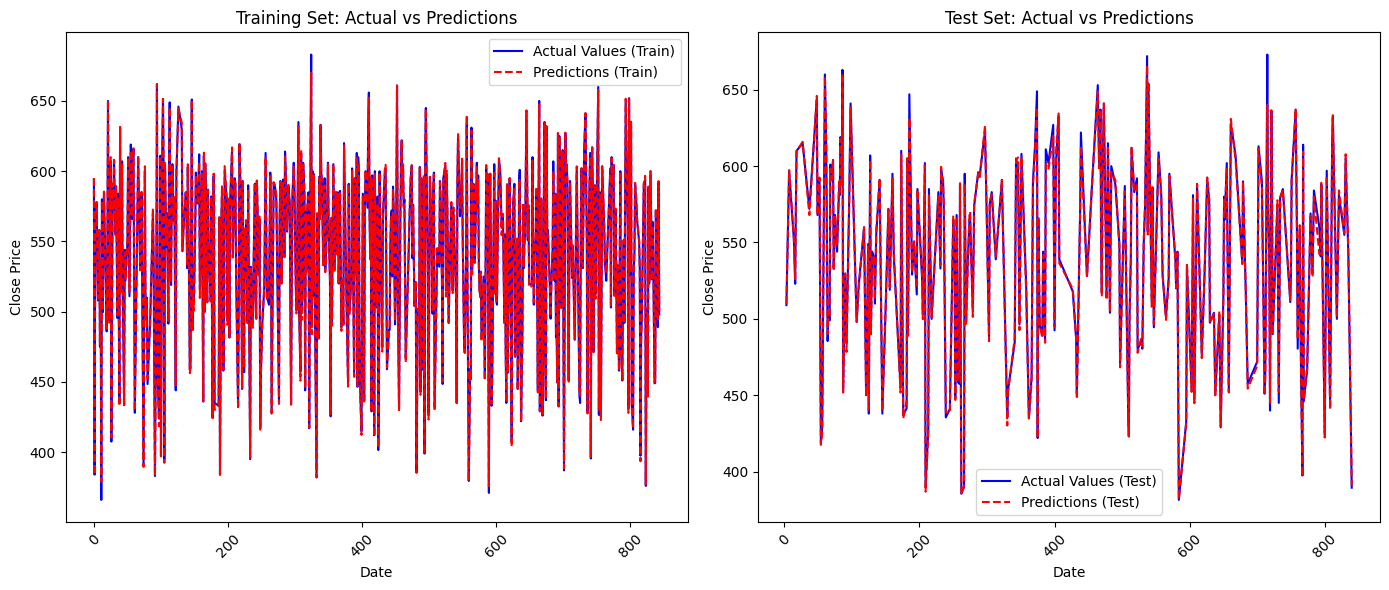

Best PCA n_components: 4
SVR with Best PCA Evaluation:
SVR with Best PCA Evaluation:
均方误差 (MSE): 123.20617530172159
均方根误差 (RMSE): 11.099827714956731
平均绝对误差 (MAE): 4.7485323021998616
R-squared score: 0.9711465932485865
在容忍度 1.0% 范围内的正确比率: 0.82
----------------------------------------


In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

def feature_selection_and_svr(features):
    tdf = pd.DataFrame()
    tdf['Target'] = data['Close']
    
    x = data[features].values
    y = tdf['Target'].values
    x_train, x_test, y_train, y_test, train_index, test_index = train_test_split(
        x, y, data.index, test_size=0.3, random_state=39830
    )

    # 特征选择
    selector = SelectKBest(score_func=f_regression, k='all')
    selector.fit(x_train, y_train)
    
    # 选择所有特征的得分
    scores = selector.scores_
    feature_scores = dict(zip(features, scores))
    sorted_features = sorted(feature_scores, key=feature_scores.get, reverse=True)
    
    # 选择前 K 个最重要的特征
    k = min(len(features), 10)  # 选择前 10 个特征，或更多/更少根据需要
    top_features = sorted_features[:k]
    print(f"Top {k} features selected: {top_features}")

    # 使用 get_loc 方法查找特征索引
    feature_index = {f: idx for idx, f in enumerate(features)}
    
    # 使用选择的特征训练 SVR
    x_train_selected = x_train[:, [feature_index[f] for f in top_features]]
    x_test_selected = x_test[:, [feature_index[f] for f in top_features]]
    svr_model = SVR(kernel='rbf', C=100, gamma='scale')
    svr_model.fit(x_train_selected, y_train)
    
    # 获取训练集和测试集的预测值
    predictions_train = svr_model.predict(x_train_selected)
    predictions_test = svr_model.predict(x_test_selected)
    
    # 打印模型评估结果
    print("SVR with Selected Features Evaluation:")
    evaluate_model(y_train, predictions_train, "SVR with Selected Features (Train)")
    evaluate_model(y_test, predictions_test, "SVR with Selected Features (Test)")

    # 绘制实际值与预测值的折线图
    plot_predictions_vs_actuals(data, train_index, test_index, y_train, y_test, predictions_train, predictions_test)

    # 使用 PCA 进行降维，评估每个 PCA 组件数下的模型
    best_n_components = 0
    best_score = -float('inf')
    best_pca = None
    best_model = None
    best_predictions = None

    # 选择 1 到特征数的范围
    for i in range(1, k + 1):
        pca = PCA(n_components=i, whiten=True)
        x_train_pca = pca.fit_transform(x_train)
        x_test_pca = pca.transform(x_test)
        
        # 使用 PCA 转换后的数据训练 SVR
        svr_model_pca = SVR(kernel='rbf', C=100, gamma='scale')
        svr_model_pca.fit(x_train_pca, y_train)
        
        predictions_pca = svr_model_pca.predict(x_test_pca)
        
        # 评估模型性能
        score = mean_squared_error(y_test, predictions_pca)
        r2 = r2_score(y_test, predictions_pca)
        
        # print(f"n_components = {i}, MSE = {score}, R-squared = {r2}")
        
        # 选择表现最佳的 PCA 组件数
        if r2 > best_score:
            best_score = r2
            best_n_components = i
            best_pca = pca
            best_model = svr_model_pca
            best_predictions = predictions_pca

    print(f'Best PCA n_components: {best_n_components}')
    # print(pca.components_)
    
    # 打印最佳 PCA 模型的评估结果
    print("SVR with Best PCA Evaluation:")
    evaluate_model(y_test, best_predictions, "SVR with Best PCA")

def plot_predictions_vs_actuals(data, train_index, test_index, y_train, y_test, predictions_train, predictions_test):
    """
    绘制训练集和测试集的实际值与预测值的折线图。
    
    Parameters:
    - data: 包含 'Close' 列的 DataFrame，索引应为日期
    - train_index: 训练集的索引
    - test_index: 测试集的索引
    - y_train: 训练集的实际值
    - y_test: 测试集的实际值
    - predictions_train: 训练集的预测值
    - predictions_test: 测试集的预测值
    """
    
    # 确保 'Date' 列是索引
    if data.index.name != 'Date':
        # 'Date' 列已经是索引
        data.index.name = 'Date'
    
    # 获取训练集和测试集的日期
    train_dates = data.index[data.index.isin(train_index)]
    test_dates = data.index[data.index.isin(test_index)]
    
    # 验证维度匹配
    if len(train_dates) != len(y_train) or len(test_dates) != len(y_test):
        raise ValueError("The length of train_dates or test_dates does not match the length of y_train or y_test.")
    
    # 绘制训练集的实际值与预测值
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_dates, y_train, label='Actual Values (Train)', color='blue')
    plt.plot(train_dates, predictions_train, label='Predictions (Train)', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.title('Training Set: Actual vs Predictions')
    plt.legend()
    plt.xticks(rotation=45)
    
    # 绘制测试集的实际值与预测值
    plt.subplot(1, 2, 2)
    plt.plot(test_dates, y_test, label='Actual Values (Test)', color='blue')
    plt.plot(test_dates, predictions_test, label='Predictions (Test)', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.title('Test Set: Actual vs Predictions')
    plt.legend()
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()


# 假设 data 是你的 DataFrame 和 features 是你的特征列表
features = ['Open', 'High', 'Low', 'Adj Close', 'Volume', 'sma', 'rsi', 'ma', 'std_dev', 'upperband', 'lowerband', 'EMA12', 'EMA26', 'MACD', 'Signal_Line', 'MACD_Histogram']
feature_selection_and_svr(features)


Top 10 features selected: ['High', 'Low', 'Open', 'Adj Close', 'EMA12', 'EMA26', 'sma', 'ma', 'upperband', 'lowerband']
SVR with Selected Features Evaluation:
SVR with Selected Features (Train) Evaluation:
均方误差 (MSE): 5.626980476804354
均方根误差 (RMSE): 2.372125729552368
平均绝对误差 (MAE): 1.722434795032284
R-squared score: 0.9988614588488859
在容忍度 1.0% 范围内的正确比率: 0.97
----------------------------------------
SVR with Selected Features (Test) Evaluation:
均方误差 (MSE): 57.452804173197535
均方根误差 (RMSE): 7.57976280454722
平均绝对误差 (MAE): 6.504803089527961
R-squared score: 0.9024927321592303
在容忍度 1.0% 范围内的正确比率: 0.46
----------------------------------------


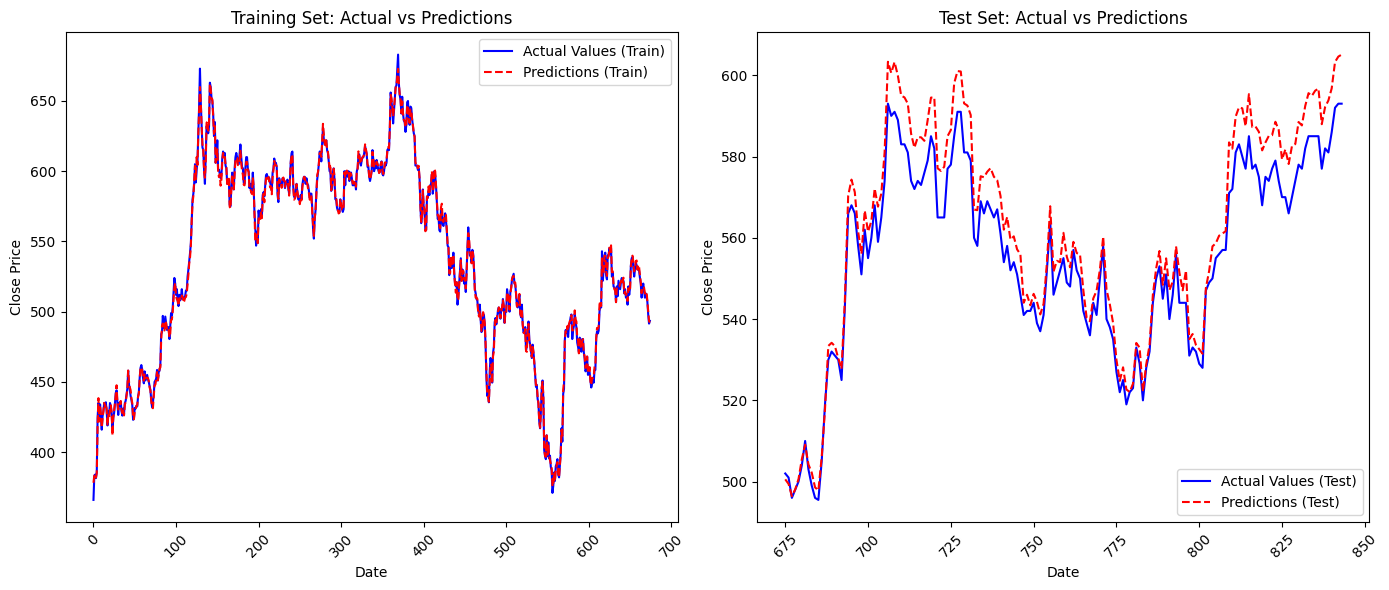

Best PCA n_components: 3
SVR with Best PCA Evaluation:
SVR with Best PCA Evaluation:
均方误差 (MSE): 22.702919149917378
均方根误差 (RMSE): 4.764758036870012
平均绝对误差 (MAE): 3.696946750671345
R-squared score: 0.9614692502798488
在容忍度 1.0% 范围内的正确比率: 0.78
----------------------------------------


In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

def feature_selection_and_svr(features):
    # 目标数据
    tdf = pd.DataFrame()
    tdf['Target'] = data['Close']
    
    # 特征数据
    x = data[features].values
    y = tdf['Target'].values
    
    # 指定训练集（前80%）和测试集（后20%）
    train_size = int(len(data) * 0.8)
    x_train, x_test = x[:train_size], x[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    # 使用整个数据集的索引作为测试集
    train_index = data.index[:train_size]
    test_index = data.index[train_size:]

    # 特征选择
    selector = SelectKBest(score_func=f_regression, k='all')
    selector.fit(x_train, y_train)
    
    # 选择所有特征的得分
    scores = selector.scores_
    feature_scores = dict(zip(features, scores))
    sorted_features = sorted(feature_scores, key=feature_scores.get, reverse=True)
    
    # 选择前 K 个最重要的特征
    k = min(len(features), 10)  # 选择前 10 个特征，或更多/更少根据需要
    top_features = sorted_features[:k]
    print(f"Top {k} features selected: {top_features}")

    # 使用 get_loc 方法查找特征索引
    feature_index = {f: idx for idx, f in enumerate(features)}
    
    # 使用选择的特征训练 SVR
    x_train_selected = x_train[:, [feature_index[f] for f in top_features]]
    x_test_selected = x_test[:, [feature_index[f] for f in top_features]]
    svr_model = SVR(kernel='rbf', C=100, gamma='scale')
    svr_model.fit(x_train_selected, y_train)
    
    # 获取训练集和测试集的预测值
    predictions_train = svr_model.predict(x_train_selected)
    predictions_test = svr_model.predict(x_test_selected)
    
    # 打印模型评估结果
    print("SVR with Selected Features Evaluation:")
    evaluate_model(y_train, predictions_train, "SVR with Selected Features (Train)")
    evaluate_model(y_test, predictions_test, "SVR with Selected Features (Test)")

    # 绘制实际值与预测值的折线图
    plot_predictions_vs_actuals(data, train_index, test_index, y_train, y_test, predictions_train, predictions_test)

    # 使用 PCA 进行降维，评估每个 PCA 组件数下的模型
    best_n_components = 0
    best_score = -float('inf')
    best_pca = None
    best_model = None
    best_predictions = None

    # 选择 1 到特征数的范围
    for i in range(1, k + 1):
        pca = PCA(n_components=i, whiten=True)
        x_train_pca = pca.fit_transform(x_train)
        x_test_pca = pca.transform(x_test)
        
        # 使用 PCA 转换后的数据训练 SVR
        svr_model_pca = SVR(kernel='rbf', C=100, gamma='scale')
        svr_model_pca.fit(x_train_pca, y_train)
        
        predictions_pca = svr_model_pca.predict(x_test_pca)
        
        # 评估模型性能
        score = mean_squared_error(y_test, predictions_pca)
        r2 = r2_score(y_test, predictions_pca)
        
        # print(f"n_components = {i}, MSE = {score}, R-squared = {r2}")
        
        # 选择表现最佳的 PCA 组件数
        if r2 > best_score:
            best_score = r2
            best_n_components = i
            best_pca = pca
            best_model = svr_model_pca
            best_predictions = predictions_pca

    print(f'Best PCA n_components: {best_n_components}')
    # print(pca.components_)
    
    # 打印最佳 PCA 模型的评估结果
    print("SVR with Best PCA Evaluation:")
    evaluate_model(y_test, best_predictions, "SVR with Best PCA")

def plot_predictions_vs_actuals(data, train_index, test_index, y_train, y_test, predictions_train, predictions_test):
    """
    绘制训练集和测试集的实际值与预测值的折线图。
    
    Parameters:
    - data: 包含 'Date' 和 'Close' 列的 DataFrame
    - train_index: 训练集的索引
    - test_index: 测试集的索引
    - y_train: 训练集的实际值
    - y_test: 测试集的实际值
    - predictions_train: 训练集的预测值
    - predictions_test: 测试集的预测值
    """
    
    # 确保 'Date' 列是索引
    if data.index.name != 'Date':
        # 'Date' 列已经是索引
        data.index.name = 'Date'
    
    # 获取训练集和测试集的日期
    train_dates = data.index[data.index.isin(train_index)]
    test_dates = data.index[data.index.isin(test_index)]
    
    # 验证维度匹配
    if len(train_dates) != len(y_train) or len(test_dates) != len(y_test):
        raise ValueError("The length of train_dates or test_dates does not match the length of y_train or y_test.")
    
    # 绘制训练集的实际值与预测值
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_dates, y_train, label='Actual Values (Train)', color='blue')
    plt.plot(train_dates, predictions_train, label='Predictions (Train)', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.title('Training Set: Actual vs Predictions')
    plt.legend()
    plt.xticks(rotation=45)
    
    # 绘制测试集的实际值与预测值
    plt.subplot(1, 2, 2)
    plt.plot(test_dates, y_test, label='Actual Values (Test)', color='blue')
    plt.plot(test_dates, predictions_test, label='Predictions (Test)', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.title('Test Set: Actual vs Predictions')
    plt.legend()
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

def evaluate_model(y_true, y_pred, model_name):
    merror = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(merror)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"{model_name} Evaluation:")
    print(f'均方误差 (MSE): {merror}')
    print(f'均方根误差 (RMSE): {rmse}')
    print(f'平均绝对误差 (MAE): {mae}')
    print(f'R-squared score: {r2}')
    tolerance_percentage = 0.01  # 1%

    # 计算容忍度阈值
    tolerance_threshold = tolerance_percentage * np.abs(y_true)

    # 计算绝对误差
    absolute_errors = np.abs(y_pred - y_true)

    # 计算在容忍度范围内的正确比率
    correct_within_tolerance = np.mean(absolute_errors <= tolerance_threshold)
    print(f'在容忍度 {tolerance_percentage*100}% 范围内的正确比率: {correct_within_tolerance:.2f}')
    print('-' * 40)

feature_selection_and_svr(features)


Top 5 features selected: ['High', 'Low', 'Open', 'Adj Close', 'EMA12']
Cross-validation MSE (without PCA): 7.8752 ± 2.7020
Cross-validation MAE (without PCA): 2.0101 ± 0.2021
Cross-validation R-squared (without PCA): 0.9981 ± 0.0007
Cross-validation SVR (without PCA) - MSE: 5.5044, MAE: 1.8908, R-squared: 0.9988
在容忍度 1.0% 范围内的正确比率: 0.96


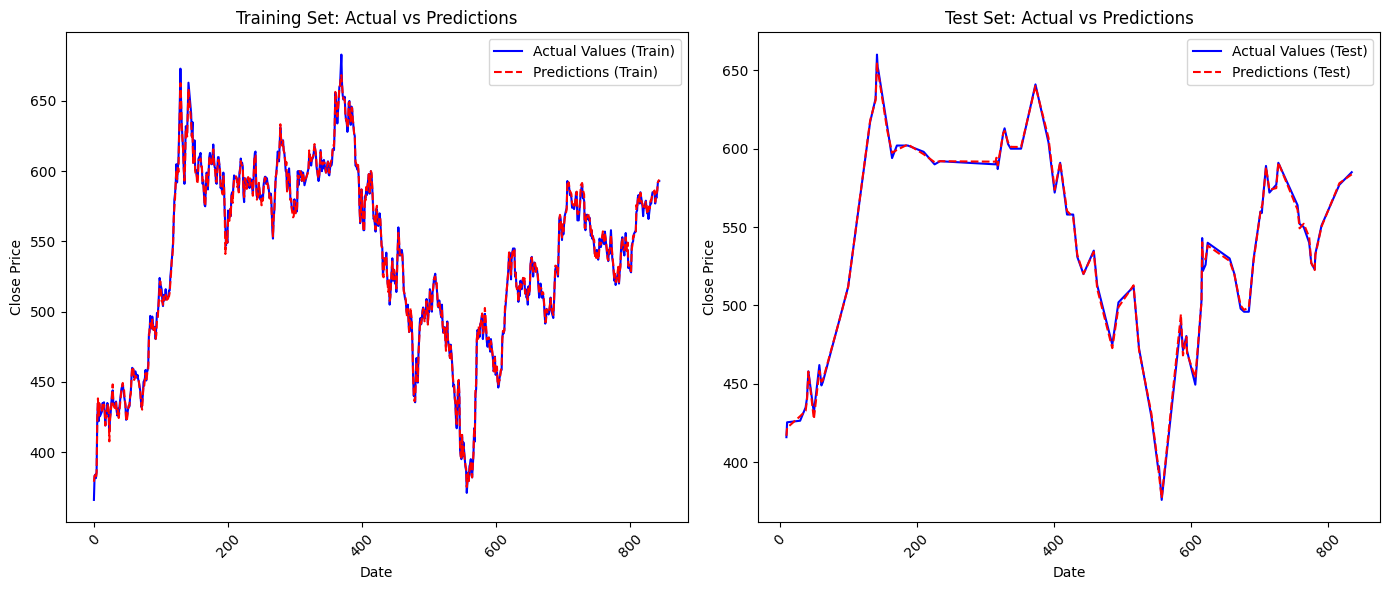

Best PCA n_components: 2
SVR with Best PCA Evaluation:
Cross-validation SVR with Best PCA - MSE: 11.4861, MAE: 2.4871, R-squared: 0.9974
在容忍度 1.0% 范围内的正确比率: 0.90


In [128]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

def evaluate_model(y_true, y_pred, label):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{label} - MSE: {mse:.4f}, MAE: {mae:.4f}, R-squared: {r2:.4f}")

    tolerance_percentage = 0.01  # 1%
    # 计算容忍度阈值
    tolerance_threshold = tolerance_percentage * np.abs(y_true)

    # 计算绝对误差
    absolute_errors = np.abs(y_pred - y_true)

    # 计算在容忍度范围内的正确比率
    correct_within_tolerance = np.mean(absolute_errors <= tolerance_threshold)
    print(f'在容忍度 {tolerance_percentage*100}% 范围内的正确比率: {correct_within_tolerance:.2f}')

def feature_selection_and_svr(features, fold):
    tdf = pd.DataFrame()
    tdf['Target'] = data['Close']
    
    x = data[features].values
    y = tdf['Target'].values

    # 特征选择
    selector = SelectKBest(score_func=f_regression, k='all')
    selector.fit(x, y)
    
    # 选择所有特征的得分
    scores = selector.scores_
    feature_scores = dict(zip(features, scores))
    sorted_features = sorted(feature_scores, key=feature_scores.get, reverse=True)
    
    # 选择前 K 个最重要的特征
    k = min(len(features), 10)  # 选择前 10 个特征，或更多/更少根据需要
    top_features = sorted_features[:k]
    print(f"Top {k} features selected: {top_features}")

    # 使用 get_loc 方法查找特征索引
    feature_index = {f: idx for idx, f in enumerate(features)}
    
    # 使用选择的特征
    x_selected = x[:, [feature_index[f] for f in top_features]]

    # 标准化特征
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(x_selected)

    # 交叉验证
    kf = KFold(n_splits=fold, shuffle=True, random_state=39830)
    
    # 没有 PCA 的 SVR
    svr_model = SVR(kernel='rbf', C=100, gamma='scale')
    
    mse_scores = []
    mae_scores = []
    r2_scores = []

    for train_index, test_index in kf.split(x_scaled):
        x_train, x_test = x_scaled[train_index], x_scaled[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        svr_model.fit(x_train, y_train)
        predictions_test = svr_model.predict(x_test)
        
        # 记录每折的评估指标
        mse_scores.append(mean_squared_error(y_test, predictions_test))
        mae_scores.append(mean_absolute_error(y_test, predictions_test))
        r2_scores.append(r2_score(y_test, predictions_test))

    print(f"Cross-validation MSE (without PCA): {np.mean(mse_scores):.4f} ± {np.std(mse_scores):.4f}")
    print(f"Cross-validation MAE (without PCA): {np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}")
    print(f"Cross-validation R-squared (without PCA): {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")
    evaluate_model(y_test, predictions_test, "Cross-validation SVR (without PCA)")

    # 绘制训练集和测试集的实际值与预测值的折线图
    # 注意：在交叉验证中，数据集被分割成多个训练集和测试集，因此这里展示的绘图是最后一个折叠的结果
    x_train, x_test = x_scaled[train_index], x_scaled[test_index]
    y_train, y_test = y[train_index], y[test_index]
    predictions_train = svr_model.predict(x_train)
    predictions_test = svr_model.predict(x_test)
    plot_predictions_vs_actuals(data, data.index[train_index], data.index[test_index], y_train, y_test, predictions_train, predictions_test)

    # 使用 PCA 进行降维，评估每个 PCA 组件数下的模型
    best_n_components = 0
    best_score = -float('inf')
    best_pca = None
    best_model = None
    best_predictions = None

    for i in range(1, k + 1):
        pca = PCA(n_components=i, whiten=True)
        x_scaled_pca = pca.fit_transform(x_scaled)
        
        mse_scores = []
        r2_scores = []

        for train_index, test_index in kf.split(x_scaled_pca):
            x_train_pca, x_test_pca = x_scaled_pca[train_index], x_scaled_pca[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            svr_model_pca = SVR(kernel='rbf', C=100, gamma='scale')
            svr_model_pca.fit(x_train_pca, y_train)
            predictions_pca = svr_model_pca.predict(x_test_pca)
            
            mse_scores.append(mean_squared_error(y_test, predictions_pca))
            r2_scores.append(r2_score(y_test, predictions_pca))

        mean_r2 = np.mean(r2_scores)
        if mean_r2 > best_score:
            best_score = mean_r2
            best_n_components = i
            best_pca = pca
            best_model = svr_model_pca

    print(f'Best PCA n_components: {best_n_components}')

    # 打印最佳 PCA 模型的评估结果
    if best_model:
        x_scaled_pca = best_pca.transform(x_scaled)
        x_train_pca, x_test_pca = x_scaled_pca[train_index], x_scaled_pca[test_index]
        y_train, y_test = y[train_index], y[test_index]
        best_predictions = best_model.predict(x_test_pca)
        
        print("SVR with Best PCA Evaluation:")
        evaluate_model(y_test, best_predictions, "Cross-validation SVR with Best PCA")

def plot_predictions_vs_actuals(data, train_index, test_index, y_train, y_test, predictions_train, predictions_test):
    """
    绘制训练集和测试集的实际值与预测值的折线图。
    
    Parameters:
    - data: 包含 'Close' 列的 DataFrame，索引应为日期
    - train_index: 训练集的索引
    - test_index: 测试集的索引
    - y_train: 训练集的实际值
    - y_test: 测试集的实际值
    - predictions_train: 训练集的预测值
    - predictions_test: 测试集的预测值
    """
    
    # 确保 'Date' 列是索引
    if data.index.name != 'Date':
        data.index.name = 'Date'
    
    # 获取训练集和测试集的日期
    train_dates = data.index[data.index.isin(train_index)]
    test_dates = data.index[data.index.isin(test_index)]
    
    # 验证维度匹配
    if len(train_dates) != len(y_train) or len(test_dates) != len(y_test):
        raise ValueError("The length of train_dates or test_dates does not match the length of y_train or y_test.")
    
    # 绘制训练集的实际值与预测值
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_dates, y_train, label='Actual Values (Train)', color='blue')
    plt.plot(train_dates, predictions_train, label='Predictions (Train)', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.title('Training Set: Actual vs Predictions')
    plt.legend()
    plt.xticks(rotation=45)
    
    # 绘制测试集的实际值与预测值
    plt.subplot(1, 2, 2)
    plt.plot(test_dates, y_test, label='Actual Values (Test)', color='blue')
    plt.plot(test_dates, predictions_test, label='Predictions (Test)', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.title('Test Set: Actual vs Predictions')
    plt.legend()
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

# 运行没有 PCA 的 SVR
feature_selection_and_svr(features=features, fold=10)


Top 10 features selected: ['High', 'Low', 'Open', 'Adj Close', 'EMA12', 'EMA26', 'sma', 'ma', 'upperband', 'lowerband']
Fold 1: MSE: 5.7574, MAE: 2.0327, R-squared: 0.9986
Fold 2: MSE: 9.9511, MAE: 2.3703, R-squared: 0.9977
Fold 3: MSE: 12.8994, MAE: 1.9999, R-squared: 0.9971
Fold 4: MSE: 11.4998, MAE: 2.3049, R-squared: 0.9977
Fold 5: MSE: 5.2152, MAE: 1.7504, R-squared: 0.9986
Fold 6: MSE: 7.6684, MAE: 1.9408, R-squared: 0.9976
Fold 7: MSE: 6.2331, MAE: 1.9763, R-squared: 0.9985
Fold 8: MSE: 5.9422, MAE: 1.8667, R-squared: 0.9984
Fold 9: MSE: 5.1361, MAE: 1.6456, R-squared: 0.9988
Fold 10: MSE: 4.3137, MAE: 1.6251, R-squared: 0.9990


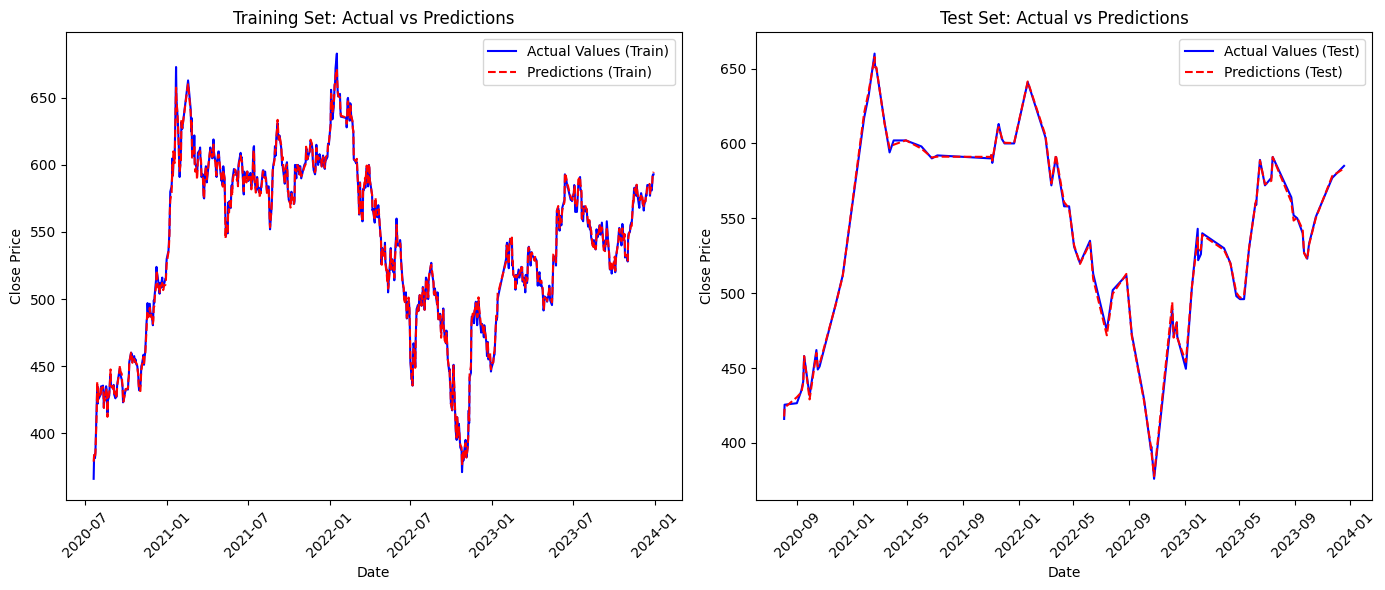


Overall Cross-validation Results (without PCA):
Mean MSE: 7.4616 ± 2.8143
Mean MAE: 1.9513 ± 0.2362
Mean R-squared: 0.9982 ± 0.0006
在容忍度 1.0% 范围内的正确比率: 0.96

Detailed Fold Results (without PCA):
   Fold        MSE       MAE  R-squared
0     1   5.757419  2.032725   0.998551
1     2   9.951059  2.370334   0.997704
2     3  12.899365  1.999905   0.997066
3     4  11.499786  2.304879   0.997684
4     5   5.215236  1.750378   0.998593
5     6   7.668356  1.940776   0.997615
6     7   6.233145  1.976298   0.998501
7     8   5.942222  1.866656   0.998438
8     9   5.136128  1.645568   0.998757
9    10   4.313699  1.625134   0.999022
Best PCA n_components: 3
SVR with Best PCA Evaluation:
Cross-validation SVR with Best PCA - MSE: 10.9170, MAE: 2.3903, R-squared: 0.9975
在容忍度 1.0% 范围内的正确比率: 0.90


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

def evaluate_model(y_true, y_pred, label):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{label} - MSE: {mse:.4f}, MAE: {mae:.4f}, R-squared: {r2:.4f}")

    tolerance_percentage = 0.01  # 1%
    # 计算容忍度阈值
    tolerance_threshold = tolerance_percentage * np.abs(y_true)

    # 计算绝对误差
    absolute_errors = np.abs(y_pred - y_true)

    # 计算在容忍度范围内的正确比率
    correct_within_tolerance = np.mean(absolute_errors <= tolerance_threshold)
    print(f'在容忍度 {tolerance_percentage*100}% 范围内的正确比率: {correct_within_tolerance:.2f}')

def feature_selection_and_svr(features, fold,tolerance_percentage):
    tdf = pd.DataFrame()
    tdf['Target'] = data['Close']
    
    x = data[features].values
    y = tdf['Target'].values

    # 特征选择
    selector = SelectKBest(score_func=f_regression, k='all')
    selector.fit(x, y)
    
    # 选择所有特征的得分
    scores = selector.scores_
    feature_scores = dict(zip(features, scores))
    sorted_features = sorted(feature_scores, key=feature_scores.get, reverse=True)
    
    # 选择前 K 个最重要的特征
    k = min(len(features), 10)  # 选择前 10 个特征，或更多/更少根据需要
    top_features = sorted_features[:k]
    print(f"Top {k} features selected: {top_features}")

    # 使用 get_loc 方法查找特征索引
    feature_index = {f: idx for idx, f in enumerate(features)}
    
    # 使用选择的特征
    x_selected = x[:, [feature_index[f] for f in top_features]]

    # # 标准化特征
    # scaler = StandardScaler()
    # x_scaled = scaler.fit_transform(x_selected)

    # 交叉验证
    kf = KFold(n_splits=fold, shuffle=True, random_state=39830)
    
    svr_model = SVR(kernel='rbf', C=100, gamma='scale')
    
    mse_scores = []
    mae_scores = []
    r2_scores = []
    fold_results = []
    all_absolute_errors = []  # 保存所有折的绝对误差

    for fold_index, (train_index, test_index) in enumerate(kf.split(x_selected), 1):
        x_train, x_test = x_selected[train_index], x_selected[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        svr_model.fit(x_train, y_train)
        predictions_test = svr_model.predict(x_test)
        
        mse = mean_squared_error(y_test, predictions_test)
        mae = mean_absolute_error(y_test, predictions_test)
        r2 = r2_score(y_test, predictions_test)
        
        mse_scores.append(mse)
        mae_scores.append(mae)
        r2_scores.append(r2)
        
        # 计算绝对误差
        absolute_errors = np.abs(predictions_test - y_test)
        all_absolute_errors.extend(absolute_errors)
        
        fold_results.append({
            'Fold': fold_index,
            'MSE': mse,
            'MAE': mae,
            'R-squared': r2
        })
        
        print(f"Fold {fold_index}: MSE: {mse:.4f}, MAE: {mae:.4f}, R-squared: {r2:.4f}")

        # 绘制最后一折的训练集和测试集的实际值与预测值的折线图
        if fold_index == fold:
            x_train, x_test = x_selected[train_index], x_selected[test_index]
            y_train, y_test = y[train_index], y[test_index]
            predictions_train = svr_model.predict(x_train)
            predictions_test = svr_model.predict(x_test)
            plot_predictions_vs_actuals(data, data.index[train_index], data.index[test_index], y_train, y_test, predictions_train, predictions_test)

    print(f"\nOverall Cross-validation Results (without PCA):")
    print(f"Mean MSE: {np.mean(mse_scores):.4f} ± {np.std(mse_scores):.4f}")
    print(f"Mean MAE: {np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}")
    print(f"Mean R-squared: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")
    
    
    tolerance_threshold = tolerance_percentage * np.mean(y)  # 基于目标变量的平均值计算容忍度阈值

    # 计算容忍度范围内的正确比率
    correct_within_tolerance = np.mean(np.array(all_absolute_errors) <= tolerance_threshold)
    print(f'在容忍度 {tolerance_percentage*100}% 范围内的正确比率: {correct_within_tolerance:.2f}')

    # 打印每一折的详细结果
    fold_results_df = pd.DataFrame(fold_results)
    print(f"\nDetailed Fold Results (without PCA):")
    print(fold_results_df)

    # 使用 PCA 进行降维，评估每个 PCA 组件数下的模型
    best_n_components = 0
    best_score = -float('inf')
    best_pca = None
    best_model = None
    best_predictions = None

    for i in range(1, k + 1):
        pca = PCA(n_components=i, whiten=True)
        x_scaled_pca = pca.fit_transform(x_selected)
        
        mse_scores = []
        r2_scores = []

        for fold_index, (train_index, test_index) in enumerate(kf.split(x_scaled_pca), 1):
            x_train_pca, x_test_pca = x_scaled_pca[train_index], x_scaled_pca[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            svr_model_pca = SVR(kernel='rbf', C=100, gamma='scale')
            svr_model_pca.fit(x_train_pca, y_train)
            predictions_pca = svr_model_pca.predict(x_test_pca)
            
            mse_scores.append(mean_squared_error(y_test, predictions_pca))
            r2_scores.append(r2_score(y_test, predictions_pca))

        mean_r2 = np.mean(r2_scores)
        if mean_r2 > best_score:
            best_score = mean_r2
            best_n_components = i
            best_pca = pca
            best_model = svr_model_pca

    print(f'Best PCA n_components: {best_n_components}')

    # 打印最佳 PCA 模型的评估结果
    if best_model:
        x_scaled_pca = best_pca.transform(x_selected)
        x_train_pca, x_test_pca = x_scaled_pca[train_index], x_scaled_pca[test_index]
        y_train, y_test = y[train_index], y[test_index]
        best_predictions = best_model.predict(x_test_pca)
        
        print("SVR with Best PCA Evaluation:")
        evaluate_model(y_test, best_predictions, "Cross-validation SVR with Best PCA")

def plot_predictions_vs_actuals(data, train_index, test_index, y_train, y_test, predictions_train, predictions_test):
    """
    绘制训练集和测试集的实际值与预测值的折线图。
    
    Parameters:
    - data: 包含 'Close' 和 'Date' 列的 DataFrame
    - train_index: 训练集的索引
    - test_index: 测试集的索引
    - y_train: 训练集的实际值
    - y_test: 测试集的实际值
    - predictions_train: 训练集的预测值
    - predictions_test: 测试集的预测值
    """
    
    # 确保 'Date' 列是日期类型
    if not pd.api.types.is_datetime64_any_dtype(data['Date']):
        data['Date'] = pd.to_datetime(data['Date'])
    
    # 获取训练集和测试集的实际日期
    train_dates = data.loc[train_index, 'Date']
    test_dates = data.loc[test_index, 'Date']
    
    # 验证维度匹配
    if len(train_dates) != len(y_train) or len(test_dates) != len(y_test):
        raise ValueError("The length of train_dates or test_dates does not match the length of y_train or y_test.")
    
    # 绘制训练集的实际值与预测值
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_dates, y_train, label='Actual Values (Train)', color='blue')
    plt.plot(train_dates, predictions_train, label='Predictions (Train)', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.title('Training Set: Actual vs Predictions')
    plt.legend()
    plt.xticks(rotation=45)
    
    # 绘制测试集的实际值与预测值
    plt.subplot(1, 2, 2)
    plt.plot(test_dates, y_test, label='Actual Values (Test)', color='blue')
    plt.plot(test_dates, predictions_test, label='Predictions (Test)', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.title('Test Set: Actual vs Predictions')
    plt.legend()
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()


# 运行没有 PCA 的 SVR
feature_selection_and_svr(features=features, fold=10,tolerance_percentage = 0.01)


Top 10 features selected: ['High', 'Low', 'Open', 'Adj Close', 'EMA12', 'upperband', 'EMA26', 'sma', 'ma', 'lowerband']
Fold 1: MSE: 6.4406, MAE: 1.1337, R-squared: 0.9998
Fold 2: MSE: 4.8984, MAE: 1.2812, R-squared: 0.9999
Fold 3: MSE: 3.6559, MAE: 1.1084, R-squared: 0.9999
Fold 4: MSE: 3.2381, MAE: 1.1456, R-squared: 0.9999
Fold 5: MSE: 5.8345, MAE: 1.1061, R-squared: 0.9998
Fold 6: MSE: 3.6033, MAE: 1.1757, R-squared: 0.9999
Fold 7: MSE: 6.5118, MAE: 1.2827, R-squared: 0.9998
Fold 8: MSE: 3.3724, MAE: 1.1369, R-squared: 0.9999
Fold 9: MSE: 3.1189, MAE: 1.1544, R-squared: 0.9999
Fold 10: MSE: 4.4695, MAE: 1.1723, R-squared: 0.9999


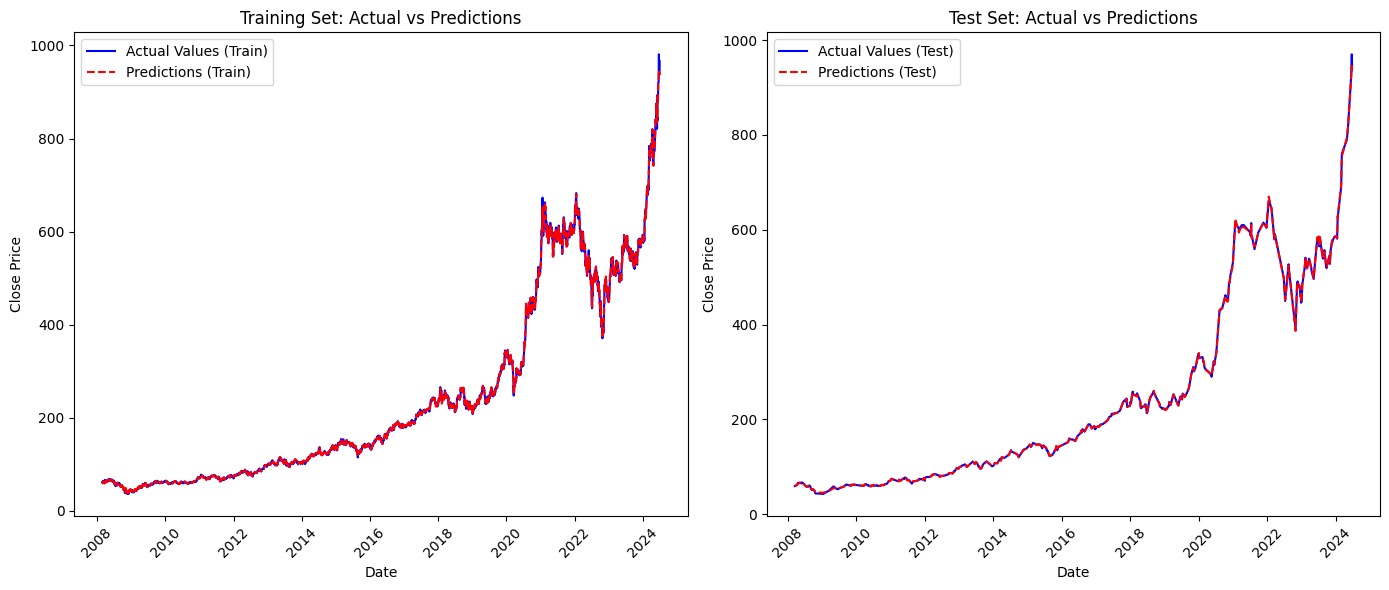


Overall Cross-validation Results (without PCA):
Mean MSE: 4.5143 ± 1.2665
Mean MAE: 1.1697 ± 0.0602
Mean R-squared: 0.9999 ± 0.0000
在容忍度 1.0% 范围内的正确比率: 0.88

Detailed Fold Results (without PCA):
   Fold       MSE       MAE  R-squared
0     1  6.440561  1.133742   0.999827
1     2  4.898390  1.281239   0.999889
2     3  3.655862  1.108450   0.999900
3     4  3.238058  1.145649   0.999926
4     5  5.834539  1.106070   0.999850
5     6  3.603281  1.175732   0.999915
6     7  6.511763  1.282726   0.999829
7     8  3.372413  1.136914   0.999916
8     9  3.118910  1.154387   0.999931
9    10  4.469541  1.172294   0.999882
Best PCA n_components: 2
SVR with Best PCA Evaluation:
Cross-validation SVR with Best PCA - MSE: 39.8485, MAE: 1.8832, R-squared: 0.9990
在容忍度 1.0% 范围内的正确比率: 0.76


In [29]:
def feature_selection_and_svr(features, fold, tolerance_percentage):
    tdf = pd.DataFrame()
    tdf['Target'] = data['Close']
    
    x = data[features].values
    y = tdf['Target'].values

    # 特征选择
    selector = SelectKBest(score_func=f_regression, k='all')
    selector.fit(x, y)
    
    # 选择所有特征的得分
    scores = selector.scores_
    feature_scores = dict(zip(features, scores))
    sorted_features = sorted(feature_scores, key=feature_scores.get, reverse=True)
    
    # 选择前 K 个最重要的特征
    k = min(len(features), 10)  # 选择前 10 个特征，或更多/更少根据需要
    top_features = sorted_features[:k]
    print(f"Top {k} features selected: {top_features}")

    # 使用 get_loc 方法查找特征索引
    feature_index = {f: idx for idx, f in enumerate(features)}
    
    # 使用选择的特征
    x_selected = x[:, [feature_index[f] for f in top_features]]

    # 交叉验证
    kf = KFold(n_splits=fold, shuffle=True, random_state=39830)
    
    svr_model = SVR(kernel='rbf', C=100, gamma='scale')
    
    mse_scores = []
    mae_scores = []
    r2_scores = []
    fold_results = []
    all_absolute_errors = []  # 保存所有折的绝对误差

    for fold_index, (train_index, test_index) in enumerate(kf.split(x_selected), 1):
        x_train, x_test = x_selected[train_index], x_selected[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        svr_model.fit(x_train, y_train)
        predictions_test = svr_model.predict(x_test)
        
        mse = mean_squared_error(y_test, predictions_test)
        mae = mean_absolute_error(y_test, predictions_test)
        r2 = r2_score(y_test, predictions_test)
        
        mse_scores.append(mse)
        mae_scores.append(mae)
        r2_scores.append(r2)
        
        # 计算绝对误差
        absolute_errors = np.abs(predictions_test - y_test)
        all_absolute_errors.extend(absolute_errors)
        
        fold_results.append({
            'Fold': fold_index,
            'MSE': mse,
            'MAE': mae,
            'R-squared': r2
        })
        
        print(f"Fold {fold_index}: MSE: {mse:.4f}, MAE: {mae:.4f}, R-squared: {r2:.4f}")

        # 绘制最后一折的训练集和测试集的实际值与预测值的折线图
        if fold_index == fold:
            x_train, x_test = x_selected[train_index], x_selected[test_index]
            y_train, y_test = y[train_index], y[test_index]
            predictions_train = svr_model.predict(x_train)
            predictions_test = svr_model.predict(x_test)
            plot_predictions_vs_actuals(data, data.index[train_index], data.index[test_index], y_train, y_test, predictions_train, predictions_test)

    print(f"\nOverall Cross-validation Results (without PCA):")
    print(f"Mean MSE: {np.mean(mse_scores):.4f} ± {np.std(mse_scores):.4f}")
    print(f"Mean MAE: {np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}")
    print(f"Mean R-squared: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}")
    
    
    tolerance_threshold = tolerance_percentage * np.mean(y)  # 基于目标变量的平均值计算容忍度阈值

    # 计算容忍度范围内的正确比率
    correct_within_tolerance = np.mean(np.array(all_absolute_errors) <= tolerance_threshold)
    print(f'在容忍度 {tolerance_percentage*100}% 范围内的正确比率: {correct_within_tolerance:.2f}')

    # 打印每一折的详细结果
    fold_results_df = pd.DataFrame(fold_results)
    print(f"\nDetailed Fold Results (without PCA):")
    print(fold_results_df)

    # 使用 PCA 进行降维，评估每个 PCA 组件数下的模型
    best_n_components = 0
    best_score = -float('inf')
    best_pca = None
    best_model = None
    best_predictions = None

    for i in range(1, k + 1):
        pca = PCA(n_components=i, whiten=True)
        x_scaled_pca = pca.fit_transform(x_selected)
        
        mse_scores = []
        r2_scores = []

        for fold_index, (train_index, test_index) in enumerate(kf.split(x_scaled_pca), 1):
            x_train_pca, x_test_pca = x_scaled_pca[train_index], x_scaled_pca[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            svr_model_pca = SVR(kernel='rbf', C=100, gamma='scale')
            svr_model_pca.fit(x_train_pca, y_train)
            predictions_pca = svr_model_pca.predict(x_test_pca)
            
            mse_scores.append(mean_squared_error(y_test, predictions_pca))
            r2_scores.append(r2_score(y_test, predictions_pca))

        mean_r2 = np.mean(r2_scores)
        if mean_r2 > best_score:
            best_score = mean_r2
            best_n_components = i
            best_pca = pca
            best_model = svr_model_pca

    print(f'Best PCA n_components: {best_n_components}')

    # 打印最佳 PCA 模型的评估结果
    if best_model:
        x_scaled_pca = best_pca.transform(x_selected)
        x_train_pca, x_test_pca = x_scaled_pca[train_index], x_scaled_pca[test_index]
        y_train, y_test = y[train_index], y[test_index]
        best_predictions = best_model.predict(x_test_pca)
        
        print("SVR with Best PCA Evaluation:")
        evaluate_model(y_test, best_predictions, "Cross-validation SVR with Best PCA")
    
    return svr_model, best_model, best_pca,top_features  # 返回 SVR 模型和最佳 PCA 模型


svr_model_no_pca, svr_model_with_pca, best_pca,selected_fea=feature_selection_and_svr(features=features, fold=10,tolerance_percentage = 0.01)

In [30]:
selected_fea

['High',
 'Low',
 'Open',
 'Adj Close',
 'EMA12',
 'upperband',
 'EMA26',
 'sma',
 'ma',
 'lowerband']

svr_model_no_pca - MSE: 9315.8958, MAE: 80.4633, R-squared: -4.7804
在容忍度 1.0% 范围内的正确比率: 0.03
svr_model_with_pca - MSE: 34902.9999, MAE: 153.8439, R-squared: -20.6567
在容忍度 1.0% 范围内的正确比率: 0.03


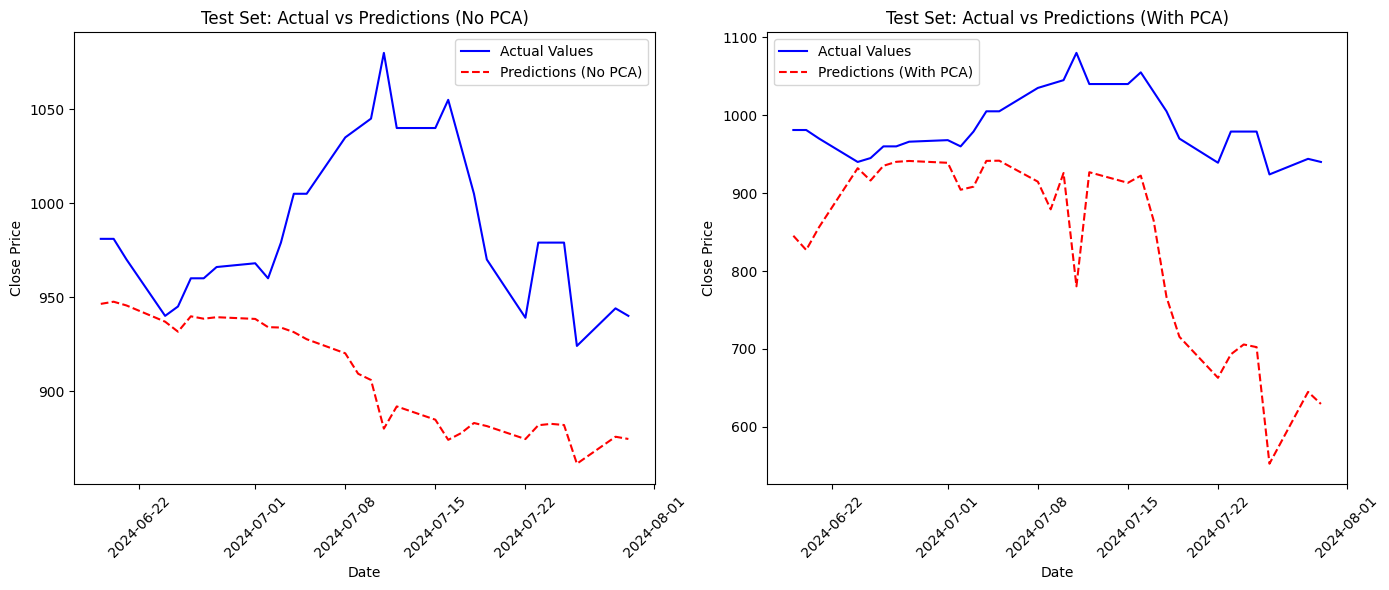

In [31]:
test_data=pd.read_csv("test.csv")
t_x=test_data[selected_fea].values
t_y=test_data['Close']

predictions_no_pca = svr_model_no_pca.predict(t_x)
evaluate_model(t_y, predictions_no_pca, "svr_model_no_pca")
# 使用最佳 PCA 模型进行预测
if best_pca:
    # 使用 PCA 进行转换
    t_x_pca = best_pca.transform(t_x)
    predictions_with_pca = svr_model_with_pca.predict(t_x_pca)
    evaluate_model(t_y, predictions_with_pca, "svr_model_with_pca")
else:
    predictions_with_pca = np.nan  # 如果没有 PCA 模型，设置为 NaN

def t_plot_predictions_vs_actuals(test_data, t_y, predictions_no_pca, predictions_with_pca=None):
    """
    绘制测试集的实际值与预测值的折线图。
    
    Parameters:
    - test_data: 包含 'Date' 列的 DataFrame
    - t_y: 测试集的实际值
    - predictions_no_pca: 使用没有 PCA 的模型的预测值
    - predictions_with_pca: 使用 PCA 的模型的预测值 (可选)
    """
    
    # 确保 'Date' 列是日期类型
    if not pd.api.types.is_datetime64_any_dtype(test_data['Date']):
        test_data['Date'] = pd.to_datetime(test_data['Date'])
    
    # 获取测试集的实际日期
    test_dates = test_data['Date']
    
    # 绘制实际值与没有 PCA 的预测值
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(test_dates, t_y, label='Actual Values', color='blue')
    plt.plot(test_dates, predictions_no_pca, label='Predictions (No PCA)', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.title('Test Set: Actual vs Predictions (No PCA)')
    plt.legend()
    plt.xticks(rotation=45)
    
    # 绘制实际值与使用 PCA 的预测值（如果有）
    if predictions_with_pca is not None:
        plt.subplot(1, 2, 2)
        plt.plot(test_dates, t_y, label='Actual Values', color='blue')
        plt.plot(test_dates, predictions_with_pca, label='Predictions (With PCA)', color='red', linestyle='--')
        plt.xlabel('Date')
        plt.ylabel('Close Price')
        plt.title('Test Set: Actual vs Predictions (With PCA)')
        plt.legend()
        plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

def evaluate_model(y_true, y_pred, label):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{label} - MSE: {mse:.4f}, MAE: {mae:.4f}, R-squared: {r2:.4f}")

    tolerance_percentage = 0.01  # 1%
    # 计算容忍度阈值
    tolerance_threshold = tolerance_percentage * np.abs(y_true)

    # 计算绝对误差
    absolute_errors = np.abs(y_pred - y_true)

    # 计算在容忍度范围内的正确比率
    correct_within_tolerance = np.mean(absolute_errors <= tolerance_threshold)
    print(f'在容忍度 {tolerance_percentage*100}% 范围内的正确比率: {correct_within_tolerance:.2f}')
# 绘制结果
t_plot_predictions_vs_actuals(test_data, t_y, predictions_no_pca, predictions_with_pca)